In [22]:
import pandas as pd

df = pd.read_csv('TSLA.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500
...,...,...,...,...,...,...,...
3063,2022-08-29,282.829987,287.739990,280.700012,284.820007,284.820007,41864700
3064,2022-08-30,287.869995,288.480011,272.649994,277.700012,277.700012,50541800
3065,2022-08-31,280.619995,281.250000,271.809998,275.609985,275.609985,52107300
3066,2022-09-01,272.579987,277.579987,266.149994,277.160004,277.160004,54287000


In [23]:
df = df[['Date', 'Close']]
df

,Date,Close
0,2010-06-29,1.592667
1,2010-06-30,1.588667
2,2010-07-01,1.464000
3,2010-07-02,1.280000
4,2010-07-06,1.074000
...,...,...
3063,2022-08-29,284.820007
3064,2022-08-30,277.700012
3065,2022-08-31,275.609985
3066,2022-09-01,277.160004


In [24]:
import datetime

def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)


In [27]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

AttributeError: 'Timestamp' object has no attribute 'split'

In [28]:
df.index = df.pop('Date')
df

,Close
Date,
2010-06-29,1.592667
2010-06-30,1.588667
2010-07-01,1.464000
2010-07-02,1.280000
2010-07-06,1.074000
...,...
2022-08-29,284.820007
2022-08-30,277.700012
2022-08-31,275.609985


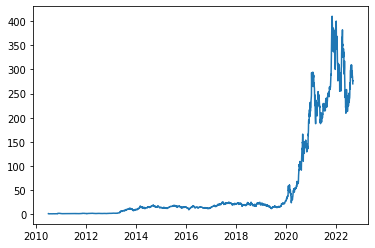

In [29]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [36]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)
    last_date  = str_to_datetime(last_date_str)

    target_date = first_date
  
    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)
    
        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
        if last_time:
            break
    
        target_date = next_date

        if target_date == last_date:
            last_time = True
    
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates
  
    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]
  
    ret_df['Target'] = Y

    return ret_df


windowed_df = df_to_windowed_df(df, 
                                '2010-07-02', 
                                '2022-09-02', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2010-07-02,1.592667,1.588667,1.464000,1.280000
1,2010-07-06,1.588667,1.464000,1.280000,1.074000
2,2010-07-07,1.464000,1.280000,1.074000,1.053333
3,2010-07-08,1.280000,1.074000,1.053333,1.164000
4,2010-07-09,1.074000,1.053333,1.164000,1.160000
...,...,...,...,...,...
3060,2022-08-29,297.096680,296.070007,288.089996,284.820007
3061,2022-08-30,296.070007,288.089996,284.820007,277.700012
3062,2022-08-31,288.089996,284.820007,277.700012,275.609985
3063,2022-09-01,284.820007,277.700012,275.609985,277.160004


In [39]:
def windowed_df_to_date_X_Y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0]

    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

    Y = df_as_np[:, -1]

    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_Y(windowed_df)

dates.shape, X.shape, y.shape

((3065,), (3065, 3, 1), (3065,))

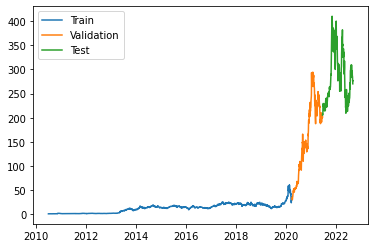

In [41]:
q_80 = int(len(dates) * 0.8)
q_90 = int(len(dates) * 0.9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]

dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [44]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras import layers

model = Sequential([layers.Input((3,1)), layers.LSTM(64), layers.Dense(32, activation='relu'), layers.Dense(32, activation='relu'), layers.Dense(1)])

model.compile(loss = 'mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)


Epoch 1/100
77/77 [==============================] - 5s 18ms/step - loss: 105.8845 - mean_absolute_error: 7.1578 - val_loss: 26425.6348 - val_mean_absolute_error: 143.6546
Epoch 2/100
77/77 [==============================] - 1s 7ms/step - loss: 8.2458 - mean_absolute_error: 0.9118 - val_loss: 21270.6641 - val_mean_absolute_error: 123.8653
Epoch 3/100
77/77 [==============================] - 0s 6ms/step - loss: 1.1199 - mean_absolute_error: 0.4189 - val_loss: 18650.9277 - val_mean_absolute_error: 113.1708
Epoch 4/100
77/77 [==============================] - 1s 7ms/step - loss: 0.5865 - mean_absolute_error: 0.3736 - val_loss: 17878.4727 - val_mean_absolute_error: 110.0355
Epoch 5/100
77/77 [==============================] - 1s 7ms/step - loss: 0.5100 - mean_absolute_error: 0.3494 - val_loss: 17456.1699 - val_mean_absolute_error: 108.3179
Epoch 6/100
77/77 [==============================] - 0s 6ms/step - loss: 0.5535 - mean_absolute_error: 0.3750 - val_loss: 17334.3555 - val_mean_absolute

77/77 [==============================] - 0s 3ms/step


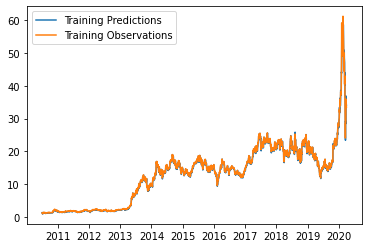

In [46]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

10/10 [==============================] - 0s 3ms/step


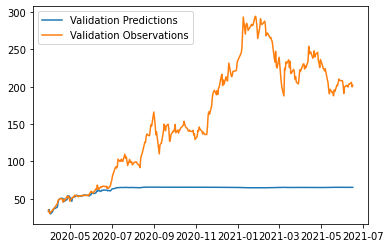

In [47]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

10/10 [==============================] - 0s 2ms/step


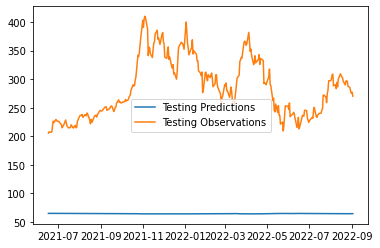

In [48]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

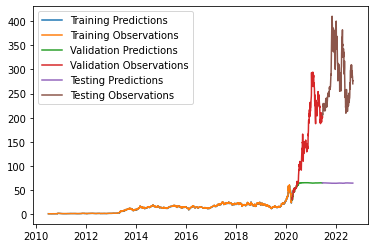

In [49]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])